# Word2Vec

Voy a utilizar word2vec para ver palabras similiares que me agrupen los Motivos de las encuestas que ya encontré con LDA, y los posibles atributos que describan al problema del cliente.

In [1]:
from collections import defaultdict
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd   
import gensim

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from gensim.matutils import cossim
from gensim.models.phrases import Phrases, Phraser
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
import nltk

import pickle
import random
import sys
from tqdm import tqdm
from sklearn import manifold
import time

start_time = time.time()

%matplotlib inline

from playsound import playsound


sys.path.append("../source")


In [2]:
import random
random.seed(100)
random_state = 100

In [3]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from gensim.models.phrases import Phrases, Phraser

In [4]:
path_df = "..\\..\\..\\data_nps\\"
path_processed = "..\\..\\..\\data_nps\\processed\\"
figures = "..\\figures\\"

In [ ]:
path_df = "..\\..\\..\\data_nps\\"
path_processed = "..\\..\\..\\data_nps\\processed\\"
dashboard = "..\\..\\..\\data_nps\\dashboard\\"
muestreo = "..\\..\\..\\data_nps\\muestreo\\"
sonido = "..\\figures\\"

In [5]:
comments = pd.read_csv(dash + "tagged.csv")
print(f"Tamaño del Dataset: {comments.shape}")

Tamaño del Dataset: (96631, 44)


In [6]:
comments = comments[comments['motivos'].str.contains("atencion")]

In [7]:
nps_dict = {
    0:"Detractor",
    1:"Detractor",
    2:"Detractor",
    3:"Detractor",
    4:"Detractor",
    5:"Detractor",
    6:"Detractor",
    7:"Neutro",
    8:"Neutro",
    9:"Promotor",
    10:"Promotor"
}

In [8]:
comments["NPS_SEGMENT"] = comments.TNPS_SCORE.apply(lambda x: nps_dict[x])

atencion["comments_clean"]= atencion["comments_clean"].apply(lambda x: re.sub(r"seguro .*","", x))
atencion["comments_clean"]= atencion["comments_clean"].apply(lambda x: re.sub(r"caja .*","", x))
atencion["comments_clean"]= atencion["comments_clean"].apply(lambda x: re.sub(r"atencion .*","", x))
atencion["comments_clean"]= atencion["comments_clean"].apply(lambda x: re.sub(r"atendieron .*","", x))

In [9]:
STOP_WORDS = stopwords.words('spanish')

def tokenize(x):
    return [word for word in word_tokenize(x) if word not in STOP_WORDS and word.isalpha() and len(word)>2]

In [11]:
comments["token"] = comments["comments_clean"].apply(lambda x:tokenize(x))

In [12]:
len(comments[comments["NPS_SEGMENT"] == "Detractor"])

3995

In [13]:
comments = comments[comments["NPS_SEGMENT"] == "Detractor"]

In [14]:
word_list = comments.token.tolist()

In [15]:
print("el corpus tiene",len(word_list), "oraciones y",sum([len(x) for x in word_list]),"palabras")

el corpus tiene 3995 oraciones y 82215 palabras


In [16]:
def sent_to_words(sentences):
    for sentence in sentences:
        #vuelve todo a lower case y saca puntuaciones y convierte cada documento de texto en una lista de palabras
        yield(gensim.utils.simple_preprocess(str(sentence), deacc =True))

In [17]:
train_w = list(sent_to_words(word_list))

In [18]:
collocations = Phrases(sentences=train_w, min_count=10,threshold=0.5,scoring='npmi') # threshold: minimo score aceptado

In [19]:
to_collocations = Phraser(collocations)

In [20]:
df_collocations =pd.DataFrame([x for x in collocations.export_phrases(train_w)],columns=["bigram","score"])
df_collocations.shape

(2978, 2)

In [21]:
df_collocations.drop_duplicates().sort_values(by="score",ascending=False).head(50)

,bigram,score
245,b'fitz roy',0.989426
1844,b'sebastian hahn',0.981269
21,b'call center',0.979615
130,b'defensa consumidor',0.942444
399,b'lomas zamora',0.923101
393,b'pack comodo',0.906928
634,b'carta documento',0.889806
258,b'debito automatico',0.879364
76,b'deja desear',0.871578
290,b'pensando seriamente',0.856363


In [22]:
trainset_ngrams = to_collocations[train_w]

In [23]:
trainset_ngrams

# Embeddings

In [24]:
bigram_reloaded = trainset_ngrams

In [25]:
w2v_model = Word2Vec(bigram_reloaded, workers=4,size=20, min_count = 10, window = 30, sample = 1e-3,negative=5,sg=1)
#w2v_model.save("word2vec_20dim")  # save model
#w2v_model = Word2Vec.load("word2vec_20dim")  # load model

In [26]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(10,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

In [27]:
from sklearn.decomposition import PCA


## Distancia entre palabras

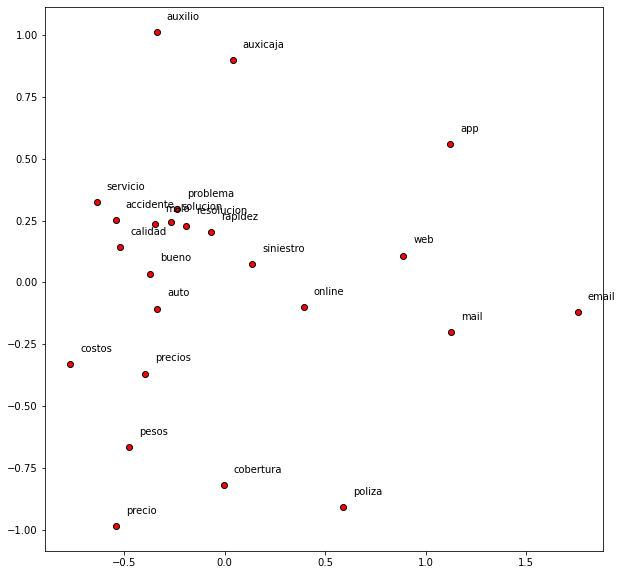

In [30]:
display_pca_scatterplot(w2v_model, 
                        ['auxilio','auxicaja','problema','malo','bueno','calidad','rapidez','costos','precios','precio','siniestro','poliza','auto','servicio','solucion','resolucion','cobertura','accidente','mail','email','pesos','online','app','web'])


## Palabras similares 

w2v_model.most_similar(positive=["malo"], topn=300)

w2v_model.most_similar(positive=["servicio"], topn=100)

In [34]:
vocab = list(w2v_model.wv.vocab)
len(vocab)

1356

In [36]:
X = w2v_model[vocab]


In [37]:
pca = PCA(n_components=3, random_state=11, whiten=True)
clf = pca.fit_transform(X)

tmp = pd.DataFrame(clf, index=vocab, columns=['x', 'y', 'z'])

tmp.head(3)

,x,y,z
malisima,-0.713347,-1.380617,-0.143335
atencion,-0.159467,-1.715254,-0.420844
telefonica,-0.488489,-1.307806,-2.283826


In [45]:
tmp = tmp.sample(100)

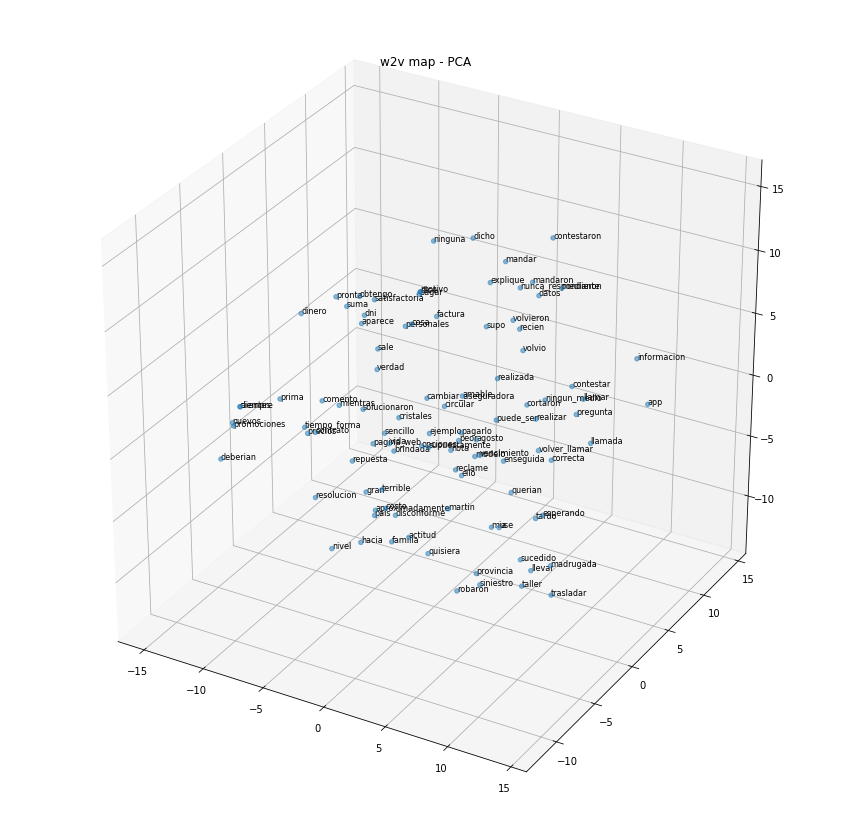

In [46]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tmp['x'], tmp['y'], tmp['z'], alpha = 0.5)

for word, row in tmp.iterrows():
    x, y, z = row
    pos = (x, y, z)
    ax.text(x, y, z, s=word, size=8, zorder=1, color='k')
    
plt.title('w2v map - PCA')
plt.show()

In [ ]:
w2v_model.wv.vocab

In [77]:
w2v_model.wv.save_word2vec_format('model_name')


In [56]:
print("--- %s segundos---" % (time.time() - start_time))
playsound(sonido+"war.mp3")
import gc 
gc.collect()

--- 90.12501549720764 segundos---


7194